In [39]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gsn.perform_gsn import perform_gsn

from scipy.ndimage import gaussian_filter1d, uniform_filter1d
from scipy.stats import pearsonr, spearmanrho

# raw: (units, time, images, trials)
def psth_gaussian(raw, sigma=3):
    # smooth along the time axis
    psth = gaussian_filter1d(raw, sigma=sigma, axis=1)
    return psth

def psth_window(raw, window_ms=50):
    # raw: (units, time, images, trials)
    # convert NaN to 0 so windowing behaves properly
    X = np.nan_to_num(raw, nan=0.0)
    # sliding window average over time axis
    psth = uniform_filter1d(X, size=window_ms, axis=1, mode='constant')
    return psth

def summary(x):
    print(f'''Summary statistics {x.shape}:
    \tMedian: {np.nanmedian(x)}
    \tMean: {np.nanmean(x)}
    \tMinimum: {np.nanmin(x)}
    \tMaximum:{np.nanmax(x)}\n''')

def segregate(df, method='truncate'):
    roi_arrays = {}
    for roi, df_roi in df.groupby('roi'):
        arrays = df_roi['raster'].to_list()
        if method == 'truncate':
            # count valid trials per unit
            valid_counts = []
            valid_masks  = []

            # minimum trials with no NaNs
            for a in arrays:
                vm = ~np.isnan(a).any(axis=(0,1))
                valid_masks.append(vm)
                valid_counts.append(vm.sum())
            min_T = min(valid_counts)
        
            total = []
            for a, vm in zip(arrays, valid_masks):
                idx = np.where(vm)[0][:min_T]   # first min_T valid trials
                total.append(a[:, :, idx])
        elif method == 'pad':
            # find max number of trials *within this ROI*
            max_T = max(a.shape[2] for a in arrays)
            total = []
            for a in arrays:
                T = a.shape[2]
                if T < max_T:
                    pad_width = ((0, 0), (0, 0), (0, max_T - T))
                    a = np.pad(a, pad_width, constant_values=np.nan)
                total.append(a)

        x_roi = np.array(total)   # (units, 450, 1072, min_T)
        roi_arrays[roi] = x_roi
        print(roi, x_roi.shape)

    return roi_arrays

def split_half_reliability_sliding(
    X,                       # [units, time, stimuli, reps]
    bin_ms=10,               # 10 ms sliding window
    onset=50,                # index offset for stim onset (your ONSET)
    start_range=(20, 200),   # ms post-onset
    end_range=(90, 390),     # ms post-onset
    min_window_ms=10,        # enforce end > start
    random_state=0,
):
    """
    for each unit, search start/end windows (10 ms steps) and return:
    - best window (start_ms, end_ms)
    - best split-half reliability (pearson r across stimuli)
    notes:
    - splits trials into two halves per stimulus (reps must be even-ish; we use floor/ceil)
    - computes mean over time-window, then mean over trials within half, per stimulus
    """
    rng = np.random.default_rng(random_state)

    U, T, S, R = X.shape
    assert R >= 4, 'need >=4 reps to split into two halves with >=2 reps each'

    # convert ms ranges to index ranges
    start_idxs = np.arange(onset + start_range[0], onset + start_range[1] + 1, bin_ms)
    end_idxs   = np.arange(onset + end_range[0],   onset + end_range[1] + 1, bin_ms)

    # precompute time-averaged responses for every possible [t0,t1) window is expensive;
    # instead, use cumulative sum over time for O(1) window means.
    # X_mean_time: [U, T, S, R]
    csum = np.cumsum(X, axis=1, dtype=np.float64)  # cumulative over time

    def time_window_mean(t0, t1):
        # mean over time axis in [t0, t1) using cumsum; returns [U, S, R]
        # guard: t1 > t0
        num = csum[:, t1 - 1] - (csum[:, t0 - 1] if t0 > 0 else 0.0)
        return num / (t1 - t0)

    best_r = np.full(U, -np.inf, dtype=np.float64)
    best_win = np.zeros((U, 2), dtype=int)

    # trial split indices per stimulus, per unit are the same (random split per unit per eval is fine).
    # simplest: for each unit, we resample splits per window (matches "randomly split").
    # if you want one split reused across windows, move the split generation outside the loops.

    for t0 in start_idxs:
        for t1 in end_idxs:
            if t1 <= t0 + (min_window_ms - 1):
                continue
            if t0 < 0 or t1 > T:
                continue

            # [U, S, R] window-averaged responses per trial
            Y = time_window_mean(t0, t1)

            # split-half reliability per unit
            r_here = np.full(U, np.nan, dtype=np.float64)

            for u in range(U):
                # per stimulus, randomly permute reps then split into halves
                # produce two vectors of length S: mean over reps in each half
                v1 = np.empty(S, dtype=np.float64)
                v2 = np.empty(S, dtype=np.float64)

                for s in range(S):
                    perm = rng.permutation(R)
                    h = R // 2
                    a = perm[:h]
                    b = perm[h:]

                    m1 = np.mean(Y[u, s, a])
                    m2 = np.mean(Y[u, s, b])
                    v1[s] = m1
                    v2[s] = m2

                # correlation across stimuli (nan-safe)
                v1m = v1 - v1.mean()
                v2m = v2 - v2.mean()
                denom = np.sqrt((v1m**2).sum() * (v2m**2).sum())
                r_here[u] = (v1m @ v2m) / denom if denom > 0 else np.nan

            # update best per unit
            better = r_here > best_r
            best_r[better] = r_here[better]
            best_win[better, 0] = t0 - onset
            best_win[better, 1] = t1 - onset

    return best_r, best_win

In [3]:
ras_df = pd.read_pickle('../../datasets/NNN/trial_raster_data_Unknown19F.pkl')
print(f'Succesfully loaded data for {len(ras_df)} units.')

roi_arrays = segregate(ras_df, method='truncate')

Succesfully loaded data for 74 units.
Unknown_19_F (74, 450, 1072, 5)


In [6]:
# ref = pd.read_pickle('./../../datasets/NNN/unit_data_full.pkl')
# roi_ref = ref[ref['roi']=='Unknown_19_F'].reset_index(drop=True)
# roi_ref['session'].unique()

In [27]:
# The input to the model was a unit × stimuli × trial matrix
# these are only single unit data
ROI = 'Unknown_19_F'
RESP = (100, 250) # this is just a random set for now
BASE = (-25, 25)
ONSET = 50

RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

# shape: (74, 450, 1072, reps) [ie. unit x time x stimuli x trial matrix]
dat = roi_arrays[ROI] 

# shape: (74, 1072, reps) [ie. unit x stimuli x trial matrix]
dat_tavg = np.mean(dat[:, RESP, :, :], axis=1) - np.mean(dat[:, BASE, :, :], axis=1)
print(dat_tavg.shape)

# results = perform_gsn(dat_tavg, {'wantshrinkage': True})

# # Let's take a look at ncsnr
# plt.figure()
# plt.hist(results['ncsnr'])
# plt.xlabel('Noise ceiling SNR')
# plt.ylabel('Frequency')
# plt.show()

# # Notice that the data covariance estimate involved some shrinkage:
# print(results['shrinklevelD'])

# # Notice that the noise covariance estimate in this case did not involve shrinkage:
# print(results['shrinklevelN'])

# # sns.heatmap(results['cSb'], vmax=np.max(results['cSb']), vmin=np.min(results['cSb']))
# sns.heatmap(results['cSb'], vmax=0.000005, vmin=0)
# summary(results['cSb'])

(74, 1072, 5)


In [26]:
# usage
X = roi_arrays[ROI]  # [units, time, stimuli, reps]
best_r, best_win = split_half_reliability_sliding(
    X,
    bin_ms=10,
    onset=50,
    start_range=(20, 200),
    end_range=(90, 390),
    random_state=0
)

# best_win is in ms post-onset (because we subtract ONSET at the end)
# each row: [start_ms, end_ms]
print('best r (first 5):', best_r[:5])
print('best windows (first 5):', best_win[:5])

best r (first 5): [0.87429902 0.53960726 0.18075044 0.15931857 0.26998927]
best windows (first 5): [[ 90 160]
 [170 390]
 [ 60 250]
 [ 80 100]
 [120 370]]


In [81]:
print('non-zero entries', np.sum(np.mean(X, axis=3)>0))
print('total entries', X.shape[0]*X.shape[1]*X.shape[2])

non-zero entries 785384
total entries 35697600


In [75]:
X = roi_arrays[ROI]  # [units, time, stimuli, reps]
scaling_factor = 1000

best_responses = []
for unit in range(len(X)):
    window = best_win[unit]
    unit_resp = X[unit, window[0]:window[1], :, :]
    baseline = X[unit, 25:75, :, :]

    baseline_subtracted = np.mean(unit_resp, axis=0) - np.mean(baseline, axis=0)
    best_responses.append(baseline_subtracted)

best_responses = np.array(best_responses)
scaled = best_responses*scaling_factor

results = perform_gsn(best_responses, {'wantshrinkage': True})

Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
done.


In [ ]:
ROI = 'Unknown_19_F'
x = roi_arrays[ROI] # shape: (608, 450, 1072, reps)
psth = psth_window(x, window_ms=50)
summary(psth)

normed = psth / np.max(psth)
summary(normed)
print(normed.shape)

# average over images
img_avg = np.mean(normed, axis=2)
# average over trials
img_avg_g = np.mean(img_avg, axis=2)
print(img_avg_g.shape)
# xt = x
# out = xt / np.nanmax(xt)
# # summary(out)
# # print(out.shape)
# psth = psth_window(out, window_ms=50)

# Perform GSN.
# We explicitly set the wantshrinkage flag to true.
results = perform_gsn(img_avg, {'wantshrinkage': True})

# Let's take a look at ncsnr
plt.figure()
plt.hist(results['ncsnr'])
plt.xlabel('Noise ceiling SNR')
plt.ylabel('Frequency')
plt.show()

# Notice that the data covariance estimate involved some shrinkage:
print(results['shrinklevelD'])

# Notice that the noise covariance estimate in this case did not involve shrinkage:
print(results['shrinklevelN'])

# # sns.heatmap(results['cSb'], vmax=np.max(results['cSb']), vmin=np.min(results['cSb']))
# sns.heatmap(results['cSb'], vmax=0.000005, vmin=0)
# summary(results['cSb'])

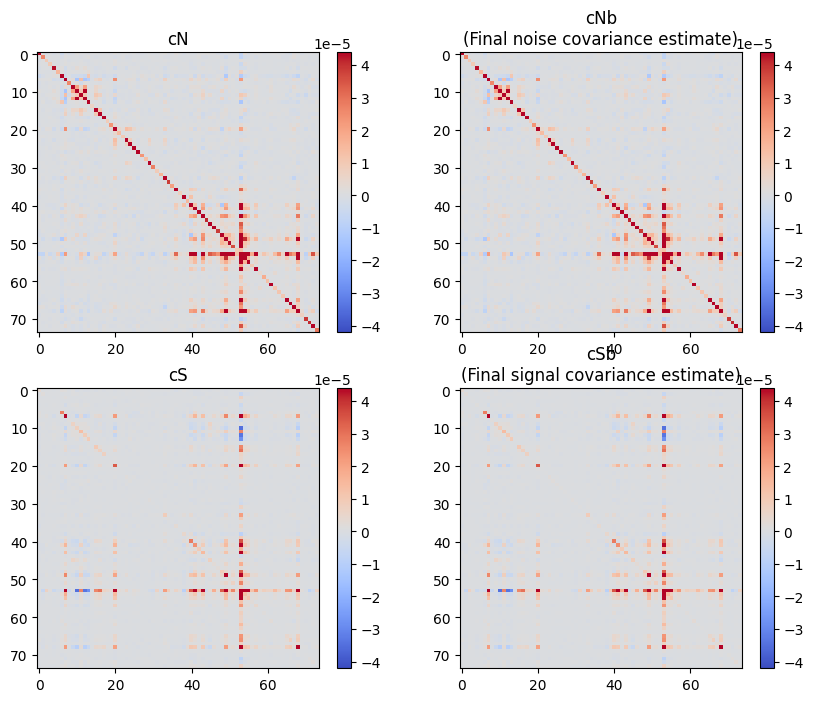

1000
Signal-noise correlation: 
	7.496428e-01
Mean off-diagonal: 
	6.800640e-07 (signal), 
	1.264377e-06 (noise)
Mean off-diagonal x 1000: 
	6.800640e-04 (signal), 
	1.264377e-03 (noise)


In [76]:
sigcov = results['cSb']
noisecov = results['cNb']

# Set range for color limits
# vrange = [np.nanmin(results['cSb']), np.nanmax(results['cSb'])]
vrange = [np.nanmean(sigcov) - 3*np.nanstd(sigcov), np.nanmean(sigcov) + 3*np.nanstd(sigcov)]
# vrange = [-0.1, 0.1]


# Visualize the covariance estimates
plt.figure(figsize=(10, 8))

# Noise covariance estimate
plt.subplot(2, 2, 1)
plt.imshow(results['cN'], vmin=vrange[0], vmax=vrange[1], aspect='auto', interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.title('cN')
plt.axis('tight')

# Final noise covariance estimate
plt.subplot(2, 2, 2)
plt.imshow(results['cNb'], vmin=vrange[0], vmax=vrange[1], aspect='auto', interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.title('cNb\n(Final noise covariance estimate)')
plt.axis('tight')

# Signal covariance estimate
plt.subplot(2, 2, 3)
plt.imshow(results['cS'], vmin=vrange[0], vmax=vrange[1], aspect='auto', interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.title('cS')
plt.axis('tight')

# Final signal covariance estimate
plt.subplot(2, 2, 4)
plt.imshow(results['cSb'], vmin=vrange[0], vmax=vrange[1], aspect='auto', interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.title('cSb\n(Final signal covariance estimate)')
plt.axis('tight')

plt.show()

sigcov = results['cSb']
noisecov = results['cNb']

print(scaling_factor)
triu = np.triu_indices_from(sigcov, k=1)
print(f'Signal-noise correlation: \n\t{pearsonr(sigcov[triu], noisecov[triu]).statistic:02e}')
print(f'Mean off-diagonal: \n\t{np.nanmean(sigcov[triu]):02e} (signal), \n\t{np.nanmean(noisecov[triu]):02e} (noise)')
print(f'Mean off-diagonal x 1000: \n\t{np.nanmean(sigcov[triu])*1000:02e} (signal), \n\t{np.nanmean(noisecov[triu])*1000:02e} (noise)')

In [45]:
np.nanmean(sigcov) + 3*np.nanstd(sigcov)

np.float64(4.3928257682256836e-05)